# Expressions dataset

Learn to auto-encode algebraic expressions of the form $x + 1 + \sin(x) + \exp(3 / x)$, i.e. expressions consting of a binary operator, a unary operator, and a unary of a binary over the four possible symbols x, 1, 2, or 3. This data was suggested by [Kusner et al. (2017)](http://proceedings.mlr.press/v70/kusner17a.html) and follows their specification. The details of the data set and the sampling procedure are specified in the `expressions_data.py` file.

Our training protocol is to train for a fixed number of $T$ epochs and sample a minibatch of $N$ trees in each epoch. We repeat this experiment 10 times and take the average auto-encoding tree edit distance on $N_\mathrm{test}$ test samples over all repeats as measure of success.

### Set up hyper-parameters of the experiment

Note: In its default format, this experiment takes quite long. If you want to speed it up, consider reducing the $T$ parameter, i.e. the number of training epochs. Further, you may want to reduce $M$, i.e. th enumber of repeats in the experiment.

In [1]:
import expressions_data
import torch

task = 'expressions'

# the number of experimental repeats
M = 10
# the number of training epochs
T = 3125
# the number of trees in each epoch (minibatch size)
N = 32
# the number of test trees
N_test = 100
# the number of training epochs for hyper-parameter optimization
T_hyper = 500
# the number of trials for hyper-parameter optimization
M_hyper = 20
# the number of data points for TES-AEs, because full 10k points exceed
# processing capabilities
N_tesae = 500

# the learning rate
learning_rate = 1E-3
# the L2 regularization strength
weight_decay = 0.

# the number of iterations between prints
print_step = 100
print_step_hyper = 100
# the update factor for the moving average
avg_factor = 0.1

# maximum size of a tree in the expressions dataset/maximum number of rules
max_size = 11

###  Specify models and model hyperparameters

In [2]:
# set up model setup functions
import dvae
import grammar_vae as gvae
import tree_echo_state_auto_encoder as tesae
import gru_tree_grammar_auto_encoder as gru_tg_ae
import recursive_tree_grammar_auto_encoder as rtg_ae

# model hyper-parameters
model_names = ['dvae', 'gvae', 'tes-ae', 'gru-tg-ae', 'rtg-ae']

# the number of neurons for all models; this is taken from Kusner's
# https://github.com/mkusner/grammarVAE/blob/master/models/model_eq.py
dim = 100
# the encoding dimensionality for the variational auto-encoder
dim_vae  = 8
# the VAE regularization strengths to try; this will be optimized later
betas_hyper = [1E-5, 1E-3, 0.01, 0.1, 1.]
# the VAE scaling parameters to try; this will be optimized later
sigma_scalings_hyper = [1E-5, 1E-3, 0.01, 0.1, 1.]
# The hyperparameters for TES-AE to try; this will be optimized later
sparsities_hyper = [0.05, 0.1, 0.2, 0.4, 0.8]
radii_hyper      = [0.5, 0.7, 0.8, 0.9, 0.95]
reguls_hyper     = [1E-7, 1E-5, 1E-3, 0.1]
# the convolutional parameters for the GVAE model, taken from the reference implementation at
# https://github.com/mkusner/grammarVAE/blob/master/models/model_eq.py
conv_params = [(2, 2), (3, 3), (4, 4)]
# the number of decoding layers for the GVAE model; again, taken from:
# https://github.com/mkusner/grammarVAE/blob/master/models/model_eq.py
gvae_layers = 3

types_idxs = {}
types = []
i = 0
for sym in expressions_data.alphabet:
    types.append(sym)
    types_idxs[sym] = i
    i += 1
def setup_dvae():
    return dvae.DVAE(max_n = max_size + 2, nvt = len(types_idxs) + 2, hs = dim, nz = dim_vae)
def setup_gvae():
    return gvae.GrammarVAE(expressions_data.grammar, dim = dim, max_len = max_size, dim_vae = dim_vae, conv_params = conv_params, gru_dim = dim, num_gru_layers = gvae_layers)
def setup_gru_tg_ae():
    return gru_tg_ae.RecurrentTreeAutoEncoder(expressions_data.grammar, dim = dim, dim_vae = dim_vae)
def setup_rtg_ae():
    return rtg_ae.TreeGrammarAutoEncoder(expressions_data.grammar, dim = dim, dim_vae = dim_vae)

setup_functions = [setup_dvae, setup_gvae, None, setup_gru_tg_ae, setup_rtg_ae]

if len(setup_functions) != len(model_names):
    raise ValueError('expected one setup function per model')

# print the number of parameters for each model
for model_idx in range(len(model_names)):
    num_params = 0
    if model_names[model_idx] == 'tes-ae':
        for nont in expressions_data.grammar._nonts:
            num_params += dim * len(expressions_data.grammar._rules[nont])
    else:
        model = setup_functions[model_idx]()
        for key in model.state_dict():
            num_params += model.state_dict()[key].numel()
    print('%s: %d parameters' % (model_names[model_idx], num_params))

dvae: 252828 parameters
gvae: 197536 parameters
tes-ae: 900 parameters
gru-tg-ae: 70025 parameters
rtg-ae: 165125 parameters


### Hyperparameter optimization (of beta and sigma_scaling)

In [3]:
import random
import os
import numpy as np
import edist.ted as ted

# try to load hyper-parameter optimization results
if os.path.exists('results/%s_rmses_hyper.csv' % task):
    errors_hyper = np.loadtxt('results/%s_rmses_hyper.csv' % task, delimiter='\t', skiprows = 1).T
else:
    errors_hyper = np.zeros((len(model_names)+2, M_hyper))
    # start the hyper-parameter optimization
    for run in range(M_hyper):
        print('--- optimization run %d of %d ---' % (run+1, M_hyper))

        # sample a random beta and sigma_scaling
        # but definitely take beta = 1 and sigma_scaling = 1 in the first run to make sure we have
        # this as a baseline
        if run == 0:
            beta = 1.
            sigma_scaling = 1.
        else:
            beta = betas_hyper[random.randrange(len(betas_hyper))]
            sigma_scaling = sigma_scalings_hyper[random.randrange(len(sigma_scalings_hyper))]
        errors_hyper[0, run] = beta
        errors_hyper[1, run] = sigma_scaling

        print('beta = %g, sigma_scaling = %g' % (beta, sigma_scaling))

        # sample trees in advance so that every model has the same training and test data
        training_data = []
        for j in range(N * T_hyper):
            nodes, adj = expressions_data.sample_tree()
            training_data.append((nodes, adj))
        test_data = []
        for j in range(N_test):
            nodes, adj = expressions_data.sample_tree()
            test_data.append((nodes, adj))

        for model_idx in range(len(model_names)):
            # ignore dvaes because the hyper-parameters are fixed by the built-in
            # training function; also ignore tes-aes because their hyperparameters are
            # different
            if model_names[model_idx] == 'dvae' or model_names[model_idx] == 'tes-ae':
                continue

            print('--- model %s ---' % model_names[model_idx])
            # set up the model
            model = setup_functions[model_idx]()

            # set up the optimizer
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
            # start training
            avg_loss = None
            for epoch in range(1, T_hyper + 1):
                optimizer.zero_grad()
                # handle a minibatch of trees
                minibatch_loss = 0.
                for j in range(N*(epoch-1), N*epoch):
                    nodes, adj = training_data[j]
                    # compute auto-encoding loss
                    loss = model.compute_loss(nodes, adj, beta = beta, sigma_scaling = sigma_scaling)
                    minibatch_loss += loss.item()
                    # compute gradient
                    loss.backward()
                # perform an optimizer step
                optimizer.step()
                # update the moving loss average
                minibatch_loss /= N
                if avg_loss is None:
                    avg_loss = minibatch_loss
                else:
                    avg_loss = (1. - avg_factor) * avg_loss + avg_factor * minibatch_loss
                if(epoch % print_step_hyper == 0):
                    print('loss avg after %d data points: %g' % (epoch * N, avg_loss))
            # evaluate generalization
            sqe = 0.
            for nodes, adj in test_data:
                # encode it
                _, z = model.encode(nodes, adj)
                # decode it again
                if len(model_names[model_idx]) >= 4 and model_names[model_idx][:4] == 'gvae':
                    nodes_act, adj_act, _ = model.decode(z)
                else:
                    nodes_act, adj_act, _ = model.decode(z, max_size = 100)
                # check tree edit distance
                d = ted.ted(nodes, adj, nodes_act, adj_act)
                # accumulate it
                sqe += d * d
            rmse = np.sqrt(sqe / N_test)
            print('obtained RMSE of %g' % rmse)
            errors_hyper[model_idx+2, run] = rmse
    # store the hyperparameter optimization data
    np.savetxt('results/%s_rmses_hyper.csv' % task, errors_hyper.T, delimiter='\t', header='\t'.join(['beta', 'sigma_scaling'] + model_names), fmt='%g', comments = '')
# select the optimal hyper-parameter for each model
betas = np.zeros(len(model_names))
sigma_scalings = np.zeros(len(model_names))
for model_idx in range(len(model_names)):
    # ignore dvaes because the hyper-parameters are fixed by the built-in training function
    if model_names[model_idx] == 'dvae' or model_names[model_idx] == 'tes-ae':
        continue
    opt_run = np.argmin(errors_hyper[model_idx+2, :])
    betas[model_idx] = errors_hyper[0, opt_run]
    sigma_scalings[model_idx] = errors_hyper[1, opt_run]
    print('optimal parameters for model %s: beta = %g, sigma_scaling = %g (error = %g)' % (model_names[model_idx], betas[model_idx], sigma_scalings[model_idx], errors_hyper[model_idx+2, opt_run]))

optimal parameters for model gvae: beta = 0.1, sigma_scaling = 0.001 (error = 5.15849)
optimal parameters for model gru-tg-ae: beta = 0.001, sigma_scaling = 0.001 (error = 4.50999)
optimal parameters for model rtg-ae: beta = 0.01, sigma_scaling = 0.1 (error = 1.38203)


### Hyperparameter optimization (of sparsity and radius for TES-AE)

In [4]:
import random
import os
import numpy as np
import edist.ted as ted

# try to load hyper-parameter optimization results
if os.path.exists('results/%s_rmses_tes_ae_hyper.csv' % task):
    errors_tesae_hyper = np.loadtxt('results/%s_rmses_tes_ae_hyper.csv' % task, delimiter='\t', skiprows = 1).T
else:
    errors_tesae_hyper = np.zeros((4, M_hyper))
    # start the hyper-parameter optimization
    for run in range(M_hyper):
        print('--- optimization run %d of %d ---' % (run+1, M_hyper))

        # sample a random sparsity and radius
        sparsity = sparsities_hyper[random.randrange(len(sparsities_hyper))]
        radius   = radii_hyper[random.randrange(len(radii_hyper))]
        regul    = reguls_hyper[random.randrange(len(reguls_hyper))]
        errors_tesae_hyper[0, run] = sparsity
        errors_tesae_hyper[1, run] = radius
        errors_tesae_hyper[2, run] = regul

        print('sparsity = %g, radius = %g, regul = %g' % (sparsity, radius, regul))

        # sample trees in advance
        training_data = []
        for j in range(N_tesae):
            nodes, adj = expressions_data.sample_tree()
            training_data.append((nodes, adj))
        test_data = []
        for j in range(N_test):
            nodes, adj = expressions_data.sample_tree()
            test_data.append((nodes, adj))

        # setup model
        model = tesae.TESAutoEncoder(expressions_data.grammar, dim = dim, sparsity = sparsity, radius = radius, regul = regul)
        # train the model
        model.fit_svm(training_data)
        # evaluate generalization
        sqe = 0.
        for nodes, adj in test_data:
            # encode it
            _, z = model.encode(nodes, adj)
            # decode it again
            nodes_act, adj_act, _ = model.decode(z, max_size = 100)
            # check tree edit distance
            d = ted.ted(nodes, adj, nodes_act, adj_act)
            # accumulate it
            sqe += d * d
        rmse = np.sqrt(sqe / N_test)
        print('obtained RMSE of %g' % rmse)
        errors_tesae_hyper[-1, run] = rmse
    # store the hyperparameter optimization data
    np.savetxt('results/%s_rmses_tes_ae_hyper.csv' % task, errors_tesae_hyper.T, delimiter='\t', header='\t'.join(['sparsity', 'radius', 'tes-ae']), fmt='%g', comments = '')
# select the optimal hyper-parameters for TES-AE
opt_run  = np.argmin(errors_tesae_hyper[-1, :])
sparsity = errors_tesae_hyper[0, opt_run]
radius   = errors_tesae_hyper[1, opt_run]
regul    = errors_tesae_hyper[2, opt_run]
print('optimal parameters for model tes-ae: sparsity = %g, radius = %g, regul = %g (error = %g)' % (sparsity, radius, regul, errors_tesae_hyper[-1, opt_run]))
# update the setup function
def setup_tes_ae():
    return tesae.TESAutoEncoder(expressions_data.grammar, dim = dim, sparsity = sparsity, radius = radius, regul = regul)
setup_functions[model_names.index('tes-ae')] = setup_tes_ae

optimal parameters for model tes-ae: sparsity = 0.4, radius = 0.7, regul = 0.001 (error = 1.77764)


### Perform the actual experiment

In [5]:
import time
import numpy as np
import edist.ted as ted
import joblib

# try to load data
import os

if os.path.exists('results/%s_runtimes.tmp' % task):
    errors   = np.loadtxt('results/%s_rmses.tmp' % task, delimiter='\t', skiprows = 1).T
    runtimes = np.loadtxt('results/%s_runtimes.tmp' % task, delimiter='\t', skiprows = 1).T
    learning_curves = np.loadtxt('results/%s_learning_curves.tmp' % task, delimiter='\t', skiprows = 1).T
else:
    errors = np.zeros((len(model_names), M))
    runtimes = np.zeros((len(model_names), M))
    learning_curves = np.zeros((len(model_names), T))

# find how many runs have already_completed
runs_completed = np.sum(np.all(runtimes > 1E-3, 0))

# start the remaining runs
for run in range(runs_completed, M):
    print('--- repeat %d of %d ---' % (run+1, M))
    
    # sample trees in advance so that every model has the same training and test data
    training_data = []
    gs = []
    for j in range(N * T):
        nodes, adj = expressions_data.sample_tree()
        training_data.append((nodes, adj))
        g, _ = dvae.tree_to_igraph(nodes, adj, types_idxs)
        gs.append(g)
    test_data = []
    for j in range(N_test):
        nodes, adj = expressions_data.sample_tree()
        test_data.append((nodes, adj))

    # check which models in the current run have already been computed
    models_left = np.argwhere(runtimes[:, run] < 1E-3)[:, 0]
    # compute the remaining models
    for model_idx in models_left:
        print('--- model %s ---' % model_names[model_idx])
        # set up the model
        model = setup_functions[model_idx]()

        start_time = time.time()
        if model_names[model_idx] != 'dvae' and model_names[model_idx] != 'tes-ae':
            # set up the optimizer
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
            # start training
            avg_loss = None
            for epoch in range(1, T + 1):
                optimizer.zero_grad()
                # handle a minibatch of trees
                minibatch_loss = 0.
                for j in range(N*(epoch-1), N*epoch):
                    nodes, adj = training_data[j]
                    # compute auto-encoding loss
                    loss = model.compute_loss(nodes, adj, beta = betas[model_idx], sigma_scaling = sigma_scalings[model_idx])
                    minibatch_loss += loss.item()
                    # compute gradient
                    loss.backward()
                # perform an optimizer step
                optimizer.step()
                # update the moving loss average
                minibatch_loss /= N
                learning_curves[model_idx, epoch-1] += minibatch_loss
                if avg_loss is None:
                    avg_loss = minibatch_loss
                else:
                    avg_loss = (1. - avg_factor) * avg_loss + avg_factor * minibatch_loss
                if(epoch % print_step == 0):
                    print('loss avg after %d data points: %g' % (epoch * N, avg_loss))
        elif model_names[model_idx] == 'dvae':
            # use the special D-VAE training function with one epoch
            learning_curve_dvae = dvae.train_dvae(model, gs, lr = learning_rate, epochs = 1, batch_size = N)
            # store the learning curve
            learning_curves[model_idx, :] += np.array(learning_curve_dvae)
        elif model_names[model_idx] == 'tes-ae':
            # use the special TES-AE training function
            model.fit_svm(training_data[:N_tesae])
        else:
            raise ValueError('internal error; unknown model name')
        runtimes[model_idx, run] = time.time() - start_time
        print('finished training after %g seconds' % runtimes[model_idx, run])
        # evaluate generalization
        sqe = 0.
        for nodes, adj in test_data:
            # encode it
            if len(model_names[model_idx]) < 4 or model_names[model_idx][:4] != 'dvae':
                _, z = model.encode(nodes, adj)
            else:
                g, _ = dvae.tree_to_igraph(nodes, adj, types_idxs)
                z, _ = model.encode([g])
            # decode it again
            if len(model_names[model_idx]) >= 4 and model_names[model_idx][:4] == 'gvae':
                nodes_act, adj_act, _ = model.decode(z)
            elif len(model_names[model_idx]) >= 4 and model_names[model_idx][:4] == 'dvae':
                g_decoded   = model.decode(z)[0]
                nodes_act, adj_act = dvae.igraph_to_tree(g_decoded, types, True)
            else:
                nodes_act, adj_act, _ = model.decode(z, max_size = 100)
            # check tree edit distance
            d = ted.ted(nodes, adj, nodes_act, adj_act)
            # accumulate it
            sqe += d * d
        rmse = np.sqrt(sqe / N_test)
        print('obtained RMSE of %g' % rmse)
        errors[model_idx, run] = rmse
        # store the best model yet
        if run == 0 or rmse < np.min(errors[model_idx, :run]):
            if model_names[model_idx] != 'tes-ae':
                torch.save(model.state_dict(), 'results/%s_%s.torch' % (task, model_names[model_idx]))
            else:
                joblib.dump(model, 'results/%s_%s.joblib' % (task, model_names[model_idx]))
    # store the data in order to continue where we left off later
    np.savetxt('results/%s_rmses.tmp' % task, errors.T, delimiter='\t', header='\t'.join(model_names), fmt='%g', comments = '')
    np.savetxt('results/%s_runtimes.tmp' % task, runtimes.T, delimiter='\t', header='\t'.join(model_names), fmt='%g', comments = '')
    np.savetxt('results/%s_learning_curves.tmp' % task, learning_curves.T, delimiter='\t', header='\t'.join(model_names), fmt='%g', comments = '')

### Visualize learning curves

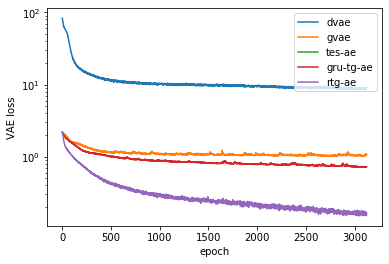

In [6]:
import matplotlib.pyplot as plt
plt.semilogy(learning_curves.T / M)
plt.legend(model_names)
plt.xlabel('epoch')
plt.ylabel('VAE loss')
plt.show()

### Store results

In [7]:
np.savetxt('results/%s_rmses.csv' % task, errors.T, delimiter='\t', header='\t'.join(model_names), fmt='%g', comments = '')
np.savetxt('results/%s_runtimes.csv' % task, runtimes.T, delimiter='\t', header='\t'.join(model_names), fmt='%g', comments = '')
np.savetxt('results/%s_learning_curves.csv' % task, learning_curves.T / M, delimiter='\t', header='\t'.join(model_names), fmt='%g', comments = '')

## Optimization

Finally, we perform optimization in the coding space of the best-performing model of every approach. In particular, we let CMA-ES run with an overall budget of 750 trees, i.e. the same budget as in the Work of [Kusner et al., 2017](http://proceedings.mlr.press/v70/kusner17a.html). The objective function is also the same as in Kusner et al., namely the comparison of the expression output in the range $[-10,10]$ and the output of the reference function $f(x) = \frac{1}{3} + x + \sin(x^2)$. The deviation is measured in terms of $\log(1 + \mathrm{MSE})$, i.e. the logarithm of one plus the mean square error on the input range.

In [9]:
# perform CMA-ES in the coding space to find optimal trees for the current task
import cma

invalid_const = 1000.

# set up the decoding functions for each model
def decode_dvae(h):
    g_decoded = model.decode(torch.tensor(h, dtype=torch.float).unsqueeze(0), stochastic = False)[0]
    nodes, adj = dvae.igraph_to_tree(g_decoded, types, True)
    return nodes, adj
def decode_gvae(h):
    nodes, adj, _ = model.decode(torch.tensor(h, dtype=torch.float))
    return nodes, adj
def decode_tes_ae(h):
    nodes, adj, _ = model.decode(h, max_size = 2*max_size)
    return nodes, adj
def decode_rtg_ae(h):
    nodes, adj, _ = model.decode(torch.tensor(h, dtype=torch.float), max_size = 2*max_size)
    return nodes, adj

decoding_functions = [decode_dvae, decode_gvae, decode_tes_ae, decode_rtg_ae, decode_rtg_ae]

# initialize the optimization results table
opt_trees = []
opt_F     = np.zeros((M, len(model_names)))

for run in range(M):
    print('--- optimization repeat %d of %d ---' % (run+1, M))
    opt_trees_run = []
    opt_trees.append(opt_trees_run)
    for model_idx in range(len(model_names)):
        print('\n--- model %s ---' % model_names[model_idx])
        # load the best-performing model from the results and setup the objective function
        if model_names[model_idx] != 'tes-ae':
            model = setup_functions[model_idx]()
            model.load_state_dict(torch.load('results/%s_%s.torch' % (task, model_names[model_idx])))
        else:
            model = joblib.load('results/%s_%s.joblib' % (task, model_names[model_idx]))
        # set up the objective function
        def objective_fun(h):
            try:
                # decode the vector via the decoding function
                nodes, adj = decoding_functions[model_idx](h)
                # return the objective function value
                return expressions_data.objective_function(nodes, adj)
            except Exception as ex:
                # return a high constant value if anything goes wrong
                return invalid_const
        # because our models are variational auto-encoders, the optimal initial Gaussian
        # for CMA-ES should be a standard Gaussian
        if model_names[model_idx] != 'tes-ae':
            mu0    = np.zeros(dim_vae)
        else:
            mu0    = np.zeros(dim)
        sigma0 = 1.
        # we set the parameter so that we have the same budget as Kusner et al. (2017)
        es = cma.CMAEvolutionStrategy(mu0, sigma0, {'popsize' : 50, 'verb_disp': 0, 'maxiter' : 15})
        # start the optimization
        es.optimize(objective_fun)
        # extract the result
        h_opt = es.result[0]
        # decode into a tree
        nodes, adj = decoding_functions[model_idx](h_opt)
        f_opt = expressions_data.objective_function(nodes, adj)
        # print the objective function value
        print('CMA-ES found the following optimal tree: %s with evaluation %g' % (expressions_data.to_algebraic_string(nodes, adj), f_opt))
        opt_trees_run.append((nodes, adj))
        opt_F[run, model_idx] = f_opt

--- optimization repeat 1 of 10 ---

--- model dvae ---
CMA-ES found the following optimal tree: x with evaluation 0.487561

--- model gvae ---
CMA-ES found the following optimal tree: x + 1 + sin(3 + 3) with evaluation 0.459831

--- model tes-ae ---
CMA-ES found the following optimal tree: x with evaluation 0.487561

--- model gru-tg-ae ---
CMA-ES found the following optimal tree: x with evaluation 0.487561

--- model rtg-ae ---
CMA-ES found the following optimal tree: x + sin(3) + sin(3) with evaluation 0.396881
--- optimization repeat 2 of 10 ---

--- model dvae ---
CMA-ES found the following optimal tree: x with evaluation 0.487561

--- model gvae ---
CMA-ES found the following optimal tree: x + sin(3) + sin(3) with evaluation 0.396881

--- model tes-ae ---
CMA-ES found the following optimal tree: x with evaluation 0.487561

--- model gru-tg-ae ---
CMA-ES found the following optimal tree: x with evaluation 0.487561

--- model rtg-ae ---
CMA-ES found the following optimal tree: 1 * 

expressions_data.py:219: RuntimeWarning: overflow encountered in exp
  return np.exp(children[0])


CMA-ES found the following optimal tree: x with evaluation 0.487561

--- model gvae ---
CMA-ES found the following optimal tree: x + 1 + sin(3 + 3) with evaluation 0.459831

--- model tes-ae ---
CMA-ES found the following optimal tree: x with evaluation 0.487561

--- model gru-tg-ae ---
CMA-ES found the following optimal tree: x with evaluation 0.487561

--- model rtg-ae ---
CMA-ES found the following optimal tree: x + sin(2) + sin(x * x) with evaluation 0.286482
--- optimization repeat 4 of 10 ---

--- model dvae ---
CMA-ES found the following optimal tree: x with evaluation 0.487561

--- model gvae ---
CMA-ES found the following optimal tree: x + 1 + sin(3 + 3) with evaluation 0.459831

--- model tes-ae ---
CMA-ES found the following optimal tree: x with evaluation 0.487561

--- model gru-tg-ae ---
CMA-ES found the following optimal tree: x with evaluation 0.487561

--- model rtg-ae ---
CMA-ES found the following optimal tree: x + 1 / 3 with evaluation 0.391134
--- optimization repea

expressions_data.py:219: RuntimeWarning: overflow encountered in exp
  return np.exp(children[0])


CMA-ES found the following optimal tree: x with evaluation 0.487561

--- model gvae ---
CMA-ES found the following optimal tree: x + 1 + sin(3 + 3) with evaluation 0.459831

--- model tes-ae ---
CMA-ES found the following optimal tree: x with evaluation 0.487561

--- model gru-tg-ae ---
CMA-ES found the following optimal tree: x with evaluation 0.487561

--- model rtg-ae ---
CMA-ES found the following optimal tree: x + sin(1) + sin(x * x) with evaluation 0.229685
--- optimization repeat 6 of 10 ---

--- model dvae ---
CMA-ES found the following optimal tree: x with evaluation 0.487561

--- model gvae ---
CMA-ES found the following optimal tree: x + sin(3) + sin(3) with evaluation 0.396881

--- model tes-ae ---
CMA-ES found the following optimal tree: x with evaluation 0.487561

--- model gru-tg-ae ---
CMA-ES found the following optimal tree: x with evaluation 0.487561

--- model rtg-ae ---
CMA-ES found the following optimal tree: x + sin(3) + sin(x * x) with evaluation 0.0362798
--- op

expressions_data.py:219: RuntimeWarning: overflow encountered in exp
  return np.exp(children[0])


CMA-ES found the following optimal tree: x with evaluation 0.487561

--- model gvae ---
CMA-ES found the following optimal tree: x + 1 + sin(3 + 3) with evaluation 0.459831

--- model tes-ae ---
CMA-ES found the following optimal tree: x with evaluation 0.487561

--- model gru-tg-ae ---
CMA-ES found the following optimal tree: x with evaluation 0.487561

--- model rtg-ae ---
CMA-ES found the following optimal tree: x + sin(2) + sin(x * x) with evaluation 0.286482
--- optimization repeat 10 of 10 ---

--- model dvae ---
CMA-ES found the following optimal tree: 3 + 3 + x with evaluation 3.49451

--- model gvae ---
CMA-ES found the following optimal tree: x + 1 + sin(3 + 3) with evaluation 0.459831

--- model tes-ae ---
CMA-ES found the following optimal tree: x with evaluation 0.487561

--- model gru-tg-ae ---
CMA-ES found the following optimal tree: x / 1 + sin(2) + sin(3 + 1) with evaluation 0.42676

--- model rtg-ae ---
CMA-ES found the following optimal tree: x + sin(3) + sin(1 / 3) 

### Store results

In [11]:
import csv
with open('results/%s_optimization.csv' % task, 'w') as csvfile:
    write = csv.writer(csvfile, delimiter='\t', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    # write header
    csv_header = []
    for model_idx in range(len(model_names)):
        csv_header.append('%s_tree_opt' % model_names[model_idx])
    for model_idx in range(len(model_names)):
        csv_header.append('%s_f_opt' % model_names[model_idx])
    write.writerow(csv_header)
    # write one row per run
    for run in range(M):
        row = []
        # write algebraic string first
        for model_idx in range(len(model_names)):
            nodes, adj = opt_trees[run][model_idx]
            row.append(expressions_data.to_algebraic_string(nodes, adj))
        # then the objective function value
        for model_idx in range(len(model_names)):
            row.append(str(opt_F[run, model_idx]))
        write.writerow(row)